# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml


2022-08-07 16:57:02.082319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-07 16:57:02.082336: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/hls4ml-0.5.1-py3.7.egg/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Settings

In [3]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 4 #number of epochs for the conversion 

weight_decay=0.00000008
patience_es = 12
patience_rlr = 5
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 3

def units(j): return (j+8)
units_range = 1

In [4]:
#quantized settings
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+8)

def bit_width(i): return {'bits': (i+8), 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 1

In [5]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/model_decay{regularizer}={weight_decay}_v{version(v)}.h5"

#path of the qconverted models
def qmodels_path(j, i): return f"tests/qmodels_test/qconverted/qmodels_units={units(j)}_epoch={nbr_conv_epoch}_batch={nbr_batch}_lr={lr}_patiencES={patience_es}_patienceRLR={patience_rlr},<{bit_lenghts(i)},{integer}>.h5"

#path of the qtrained models
def qtrained_models_path(j, i, v ): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_patiencES={patience_es}_patienceRLR={patience_rlr}_delta={delta}_cp,<{bit_lenghts(i)},{integer}>v{version(v)}.h5"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"

## Data creation 

In [6]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("/atlas/bonnet/Desktop/code/internship_CPPM/data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()



shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


# 1. Classic Network


## Training of the classic model

In [7]:
import os

testing new weights
14063/14063 [==============================] - 33s 2ms/step - loss: 3.2803e-05 - val_loss: 1.4130e-05 - lr: 0.0010
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 31s 2ms/step - loss: 1.4262e-05 - val_loss: 1.4689e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.3797e-05 - val_loss: 1.2687e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 30s 2m

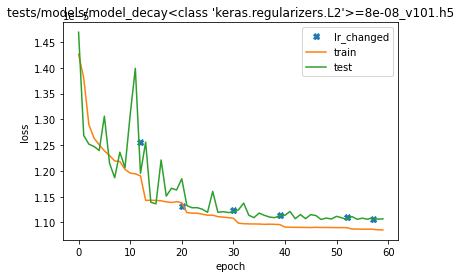

number of units  8
testing new weights
14063/14063 [==============================] - 35s 2ms/step - loss: 2.0597e-05 - val_loss: 1.2581e-05 - lr: 0.0010
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.2791e-05 - val_loss: 1.3067e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.2507e-05 - val_loss: 1.1947e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [=====================

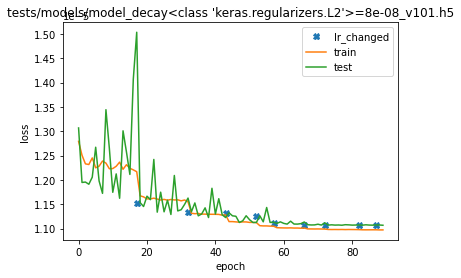

number of units  8
testing new weights
14063/14063 [==============================] - 32s 2ms/step - loss: 4.2128e-05 - val_loss: 1.7519e-05 - lr: 0.0010
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.8055e-05 - val_loss: 1.7003e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.6842e-05 - val_loss: 1.9086e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [=====================

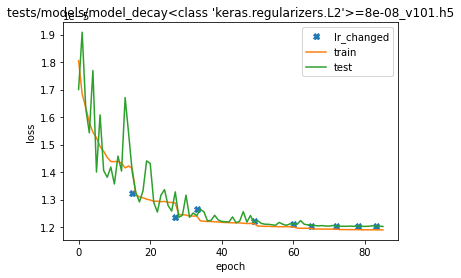

number of units  8


In [10]:
def normal_model (units_parameter):
    
    checkpoint_filepath = '/atlas/bonnet/Desktop/code/internship_CPPM/rnn/model_checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience= patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)

    val_loss = 1


    # restart training if the model does not start converging by the end of first epoch
    while val_loss > 0.0005:
        print("testing new weights")
        r_model = Sequential()
        r_model.add(SimpleRNN(units_parameter, activation='relu', input_shape=(time_step, 1), return_sequences=False, name='SimpleRNN',
                                kernel_regularizer=regularizer(weight_decay), recurrent_regularizer=regularizer(weight_decay), bias_regularizer=regularizer(weight_decay)))
        r_model.add(Dense(output, activation='relu',name='dense',
                             kernel_regularizer=regularizer(weight_decay), bias_regularizer=regularizer(weight_decay)))
        r_model.compile(loss="mean_squared_error", optimizer=Adam(lr))
        history = r_model.fit(x,y,validation_data=(x_val,y_val), epochs=1, batch_size=nbr_batch, shuffle=True, callbacks=[early_stopping, reduce_lr])
        val_loss = history.history['val_loss'][0]


    r_model.summary()

    hist = r_model.fit(x,y,validation_data=(x_val,y_val), epochs=nbr_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])
    lr_change = []
    for i in range (len(hist.history['lr'])-1):
    
        if (hist.history['lr'][i]==hist.history['lr'][i+1]):
            lr_change.append(None)
        else: 
            lr_change.append(hist.history['val_loss'][i+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(models_path(101))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()
    return r_model

def model_training (): 
    models =[]

    for j in range(units_range):
        units_parameter = units(j)
        for v in range(versions_range):

            if (os.path.exists(models_path(v))==False):
                model = normal_model(units_parameter)
                models.append(model)
                model.save(models_path(v))
                print('number of units ', units_parameter)  
            else : print(f'{models_path(v)} already exists')       
    return models

models = model_training()

In [31]:
mref = tf.keras.models.load_model("../time_step_test/tests/models/model_timestep=5v0.h5")
#y_kerasref=m.predict(x_test)


In [34]:
m1=tf.keras.models.load_model("tests/models/model_decayl1=1e-06_v0.h5")

In [46]:
m3 = tf.keras.models.load_model(models_path(0))
y_keras3=m3.predict(x_test)


31250/31250 [==============================] - 34s 1ms/step


1.6720516e-05
1.0860551e-05
9.9454e-06
9.8155915e-06


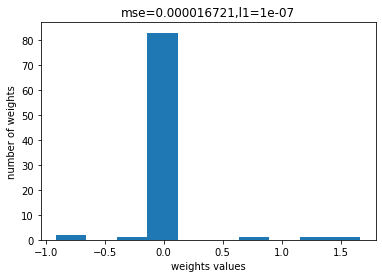

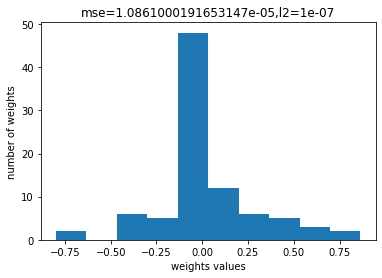

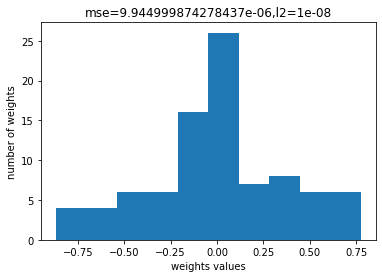

9.945e-06


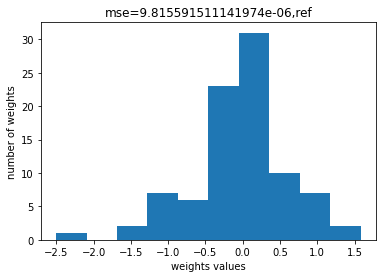

In [66]:
loss=mse(y_test,y_keras)
print(loss)
loss2=mse(y_test,y_keras2)
print(loss2)
loss3=mse(y_test,y_keras3)
print(loss3)
lossref=mse(y_test,y_kerasref)
print(lossref)
loss3=round(loss3,9)
plt.ylabel("number of weights")
plt.xlabel("weights values")
plt.hist(np.concatenate([i.flatten() for i in m1.get_weights()]))
plt.title(f"mse={loss:.9f},l1={weight_decay*10}")
plt.show()

plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
plt.hist(np.concatenate([i.flatten() for i in m2.get_weights()]))
plt.title(f"mse={round(loss2,9)},l2={weight_decay*10}")
plt.show()

plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
plt.hist(np.concatenate([i.flatten() for i in m3.get_weights()]))
plt.title(f"mse={loss3},l2={weight_decay}")
plt.show()
print(loss3)
plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
plt.hist(np.concatenate([i.flatten() for i in mref.get_weights()]))
plt.title(f"mse={lossref},ref")
plt.show()

# 2. Quantizing it 

## Quantization conversion

In [13]:
def quantized_conv_model (bits, units_parameter, model_to_convert):  


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, verbose=1) 
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(units_parameter,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr))
    
    qr_model.summary()
    #using the weight from the classic network as a base
    qr_model.set_weights(model_to_convert.get_weights())
    qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_conv_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_conv_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            if (os.path.exists(qmodels_path(j,i))==False):
                qmodel = quantized_conv_model(bits_parameter, units(j), tf.keras.models.load_model(models_path(j)))
                qmodel.save(qmodels_path(j,i))
                qmodels.append(qmodel)
            else : print(f'{qmodels_path(j,i)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_conv_training()

OSError: No file or directory found at tests/models_test/epochs=200/models_units=4_batch=32_lr=0.001_patiencES=8_patienceRLR=5.h5

31250/31250 [==============================] - 32s 1ms/step


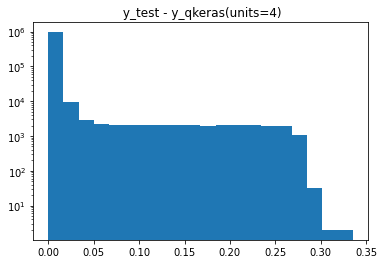

31250/31250 [==============================] - 32s 1ms/step


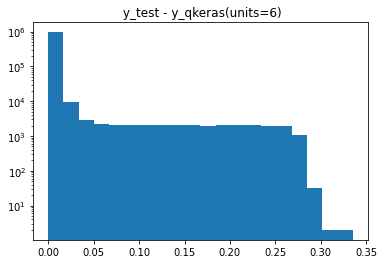

31250/31250 [==============================] - 33s 1ms/step


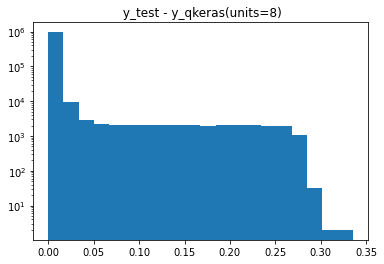

31250/31250 [==============================] - 33s 1ms/step


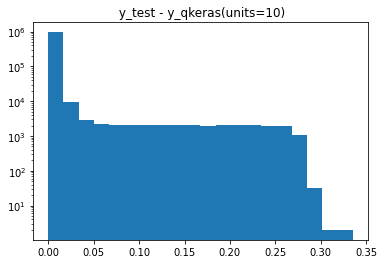

31250/31250 [==============================] - 32s 1ms/step


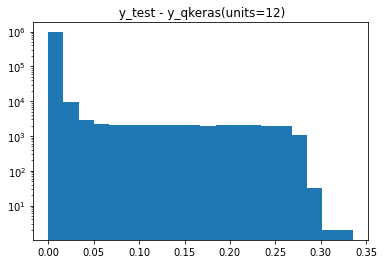

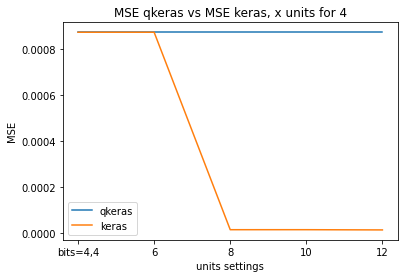

31250/31250 [==============================] - 34s 1ms/step


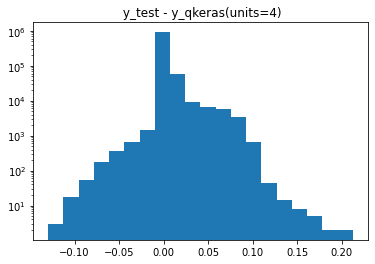

31250/31250 [==============================] - 33s 1ms/step


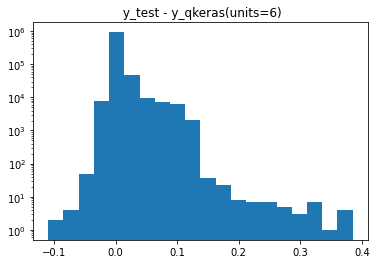

31250/31250 [==============================] - 33s 1ms/step


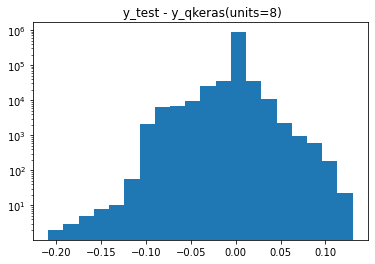

31250/31250 [==============================] - 34s 1ms/step


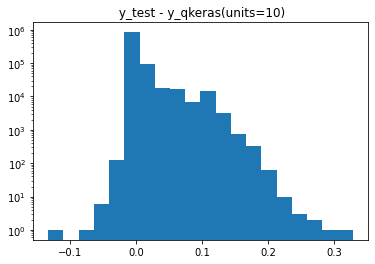

31250/31250 [==============================] - 32s 1ms/step


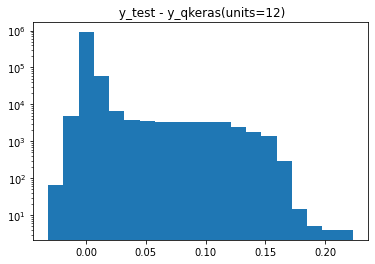

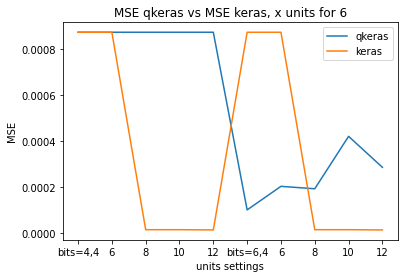

31250/31250 [==============================] - 34s 1ms/step


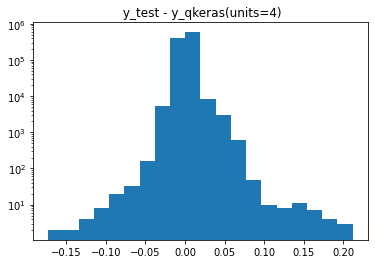

31250/31250 [==============================] - 34s 1ms/step


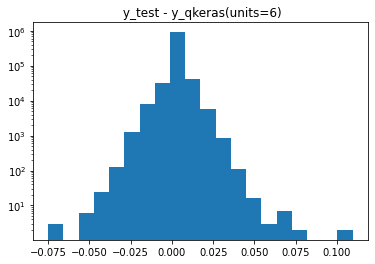

31250/31250 [==============================] - 35s 1ms/step


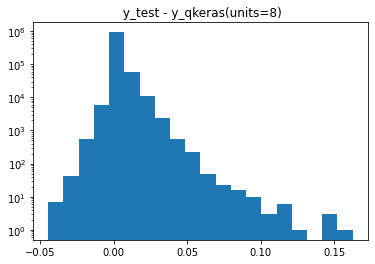

31250/31250 [==============================] - 34s 1ms/step


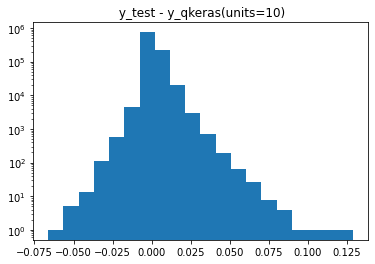

31250/31250 [==============================] - 34s 1ms/step


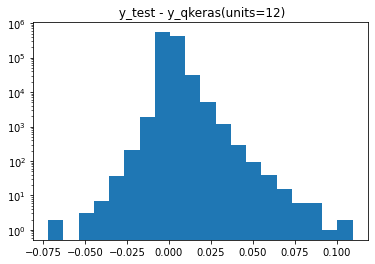

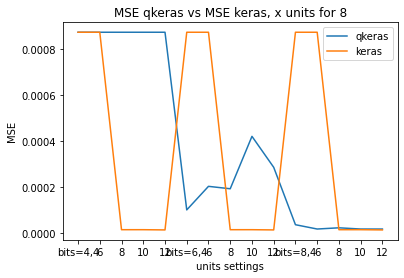

31250/31250 [==============================] - 35s 1ms/step


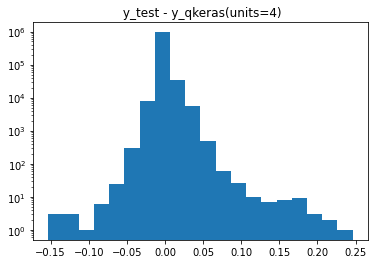

31250/31250 [==============================] - 38s 1ms/step


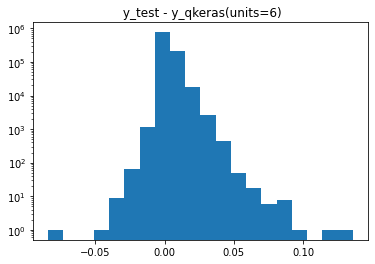

31250/31250 [==============================] - 33s 1ms/step


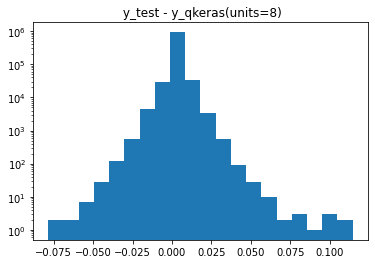

31250/31250 [==============================] - 34s 1ms/step


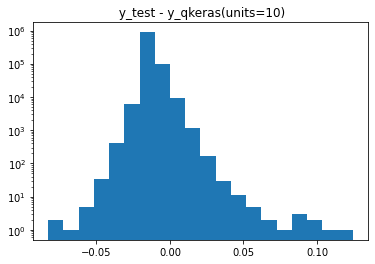

31250/31250 [==============================] - 33s 1ms/step


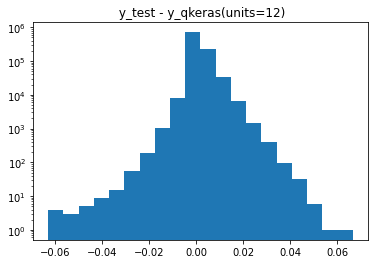

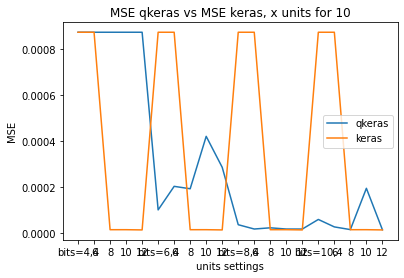

31250/31250 [==============================] - 36s 1ms/step


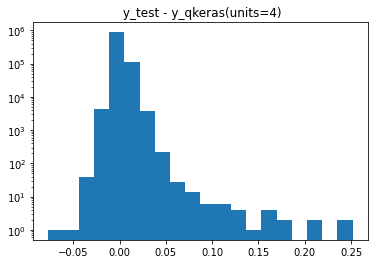

31250/31250 [==============================] - 33s 1ms/step


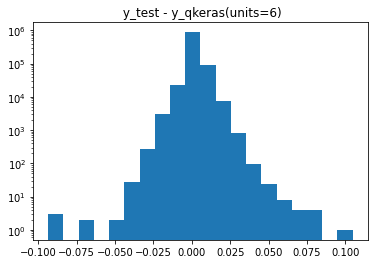

31250/31250 [==============================] - 37s 1ms/step


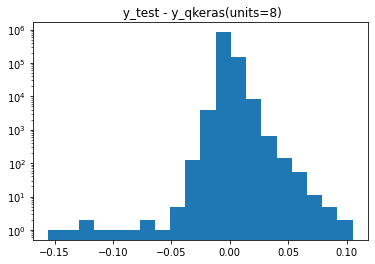

31250/31250 [==============================] - 34s 1ms/step


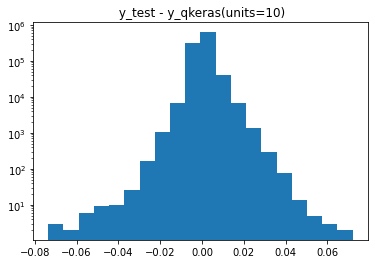

31250/31250 [==============================] - 36s 1ms/step


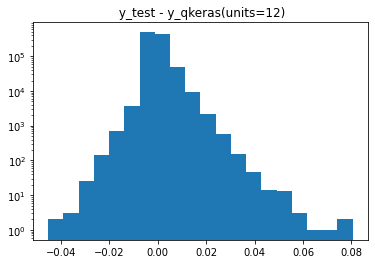

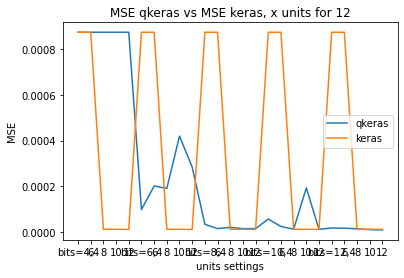

In [10]:
bit_nbr = []
loss1 = [] 
loss2 = []
unit_nbr = []

for i in range(bits_range):

    bit_nbr.append(bit_lenghts(i))
    for j in range (units_range):
        if (j==0):
            unit_nbr.append(f'bits={bit_lenghts(i)},{units(j)}')
        else: 
            unit_nbr.append(f'{units(j)}')
        qmodel = qkeras.utils.load_qmodel(qmodels_path(j,i))        
        y_qkeras = qmodel.predict(x_test)
        model = tf.keras.models.load_model(models_path(j))
        y_keras = model.predict(x_test)

        loss1.append(mse(y_test,y_qkeras))        
        loss2.append(mse(y_test,y_keras))

        plt.figure()
        plt.hist(y_test-y_qkeras, bins=20)
        plt.yscale('log')
        plt.title(f' y_test - y_qkeras(units={units(j)})')
        plt.show()
        
    plt.figure()
    plt.plot(loss1)
    plt.plot(loss2)
    plt.legend(['qkeras','keras'])
    plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
    plt.xlabel('units settings')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras vs MSE keras, x units for {bit_lenghts(i)}')
    plt.show()

## Quantization training 

14063/14063 [==============================] - 35s 2ms/step - loss: 3.1208e-05 - val_loss: 1.5172e-05 - lr: 0.0010
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_6 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_6 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.5441e-05 - val_loss: 1.4837e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.4614e-05 - val_loss: 1.4448e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.421

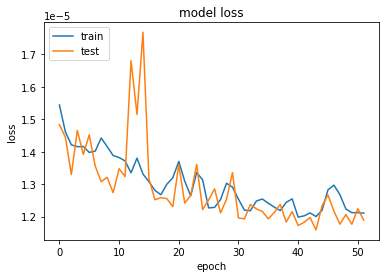

14063/14063 [==============================] - 36s 2ms/step - loss: 2.2067e-05 - val_loss: 1.7598e-05 - lr: 0.0010
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_8 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_8 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 34s 2ms/step - loss: 1.5795e-05 - val_loss: 1.5051e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.5187e-05 - val_loss: 1.5081e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 31s 2ms/step - loss: 1.495

In [10]:
def quantized_model (bits, units_parameter,):  
    losses = []
    checkpoint_filepath = '/atlas/bonnet/Desktop/code/internship_CPPM/rnn/model_checkpoint'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)

    val_loss = 1


    # restart training if the model does not start converging by the end of first epoch
    while val_loss > 0.0005:
        qr_model = Sequential()
        qr_model.add(QSimpleRNN(units_parameter,
                            input_dim= 1,
                            activation='relu',
                            kernel_quantizer=quantized_bits(**bits),
                            recurrent_quantizer=quantized_bits(**bits),
                            bias_quantizer=quantized_bits(**bits)    
                            )) 
        qr_model.add(QDense(output, 
                            activation='relu',
                            kernel_quantizer=quantized_bits(**bits),
                            bias_quantizer=quantized_bits(**bits) ))
        qr_model.compile(loss="mse", optimizer=Adam(lr))
        history = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = 1, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback,early_stopping, reduce_lr,tensorboard_callback])

        val_loss = history.history['val_loss'][0]

        
    qr_model.summary()

    hist = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs =nbr_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback,early_stopping, reduce_lr,tensorboard_callback])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return qr_model

def qmodel_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            for v in range(versions_range):
                if (os.path.exists(qtrained_models_path(j,i,v))==False):
                    units_parameter = units(j)
                    qmodel = quantized_model(bits_parameter, units_parameter)
                    qmodel.save(qtrained_models_path(j,i,v))
                    qmodels.append(qmodel)
                else : print(f'{qtrained_models_path(j,i,v)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_training()
        